In [1]:
!pip install python-box timm pytorch-lightning==1.4.0 grad-cam ttach

In [2]:
%pip install -q "pytorch-lightning==1.9.5" "torchmetrics==0.11.4"


Note: you may need to restart the kernel to use updated packages.


In [5]:
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule
import warnings; warnings.filterwarnings("ignore")
print("PL:", pl.__version__)


PL: 1.9.5


In [7]:
%pip install -q --upgrade pip
%pip install -q "pytorch-lightning==1.9.5" "torchmetrics==0.11.4"


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [8]:
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule
import warnings; warnings.filterwarnings("ignore")
print("PL:", pl.__version__)


PL: 1.9.5


In [11]:
%pip install -q grad-cam opencv-python-headless

Note: you may need to restart the kernel to use updated packages.


In [13]:
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image

print("grad-cam OK")

grad-cam OK


In [45]:
import os
import warnings
from pprint import pprint
from glob import glob
from tqdm import tqdm

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as T
from box import Box
from timm import create_model
from sklearn.model_selection import StratifiedKFold
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image


import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import LightningDataModule, LightningModule


warnings.filterwarnings("ignore")

## config

In [48]:
config = {'seed': 2021,
          'root': '/kaggle/input/petfinder-pawpularity-score/', 
          'n_splits': 5,
          'epoch': 20,
          'trainer': {
              'gpus': 1,
              'accumulate_grad_batches': 1,
              'progress_bar_refresh_rate': 1,
              'fast_dev_run': False,
              'num_sanity_val_steps': 0,
              'resume_from_checkpoint': None,
          },
          'transform':{
              'name': 'get_default_transforms',
              'image_size': 224
          },
          'train_loader':{
              'batch_size': 64,
              'shuffle': True,
              'num_workers': 4,
              'pin_memory': False,
              'drop_last': True,
          },
          'val_loader': {
              'batch_size': 64,
              'shuffle': False,
              'num_workers': 4,
              'pin_memory': False,
              'drop_last': False
         },
          'model':{
              'name': 'swin_tiny_patch4_window7_224',
              'output_dim': 1
          },
          'optimizer':{
              'name': 'optim.AdamW',
              'params':{
                  'lr': 1e-5
              },
          },
          'scheduler':{
              'name': 'optim.lr_scheduler.CosineAnnealingWarmRestarts',
              'params':{
                  'T_0': 20,
                  'eta_min': 1e-4,
              }
          },
          'loss': 'nn.BCEWithLogitsLoss',
}

config = Box(config)

In [50]:
pprint(config)

{'epoch': 20,
 'loss': 'nn.BCEWithLogitsLoss',
 'model': Box({'name': 'swin_tiny_patch4_window7_224', 'output_dim': 1}),
 'n_splits': 5,
 'optimizer': Box({'name': 'optim.AdamW', 'params': {'lr': 1e-05}}),
 'root': '/kaggle/input/petfinder-pawpularity-score/',
 'scheduler': {'name': 'optim.lr_scheduler.CosineAnnealingWarmRestarts',
               'params': Box({'T_0': 20, 'eta_min': 0.0001})},
 'seed': 2021,
 'train_loader': {'batch_size': 64,
                  'drop_last': True,
                  'num_workers': 4,
                  'pin_memory': False,
                  'shuffle': True},
 'trainer': {'accumulate_grad_batches': 1,
             'fast_dev_run': False,
             'gpus': 1,
             'num_sanity_val_steps': 0,
             'progress_bar_refresh_rate': 1,
             'resume_from_checkpoint': None},
 'transform': Box({'name': 'get_default_transforms', 'image_size': 224}),
 'val_loader': {'batch_size': 64,
                'drop_last': False,
                'num_worke

## dataset

In [53]:
class PetfinderDataset(Dataset):
    def __init__(self, df, image_size=224):
        self._X = df["Id"].values
        self._y = None
        if "Pawpularity" in df.keys():
            self._y = df["Pawpularity"].values
        self._transform = T.Resize([image_size, image_size])

    def __len__(self):
        return len(self._X)

    def __getitem__(self, idx):
        image_path = self._X[idx]
        image = read_image(image_path)
        image = self._transform(image)
        if self._y is not None:
            label = self._y[idx]
            return image, label
        return image

class PetfinderDataModule(LightningDataModule):
    def __init__(
        self,
        train_df,
        val_df,
        cfg,
    ):
        super().__init__()
        self._train_df = train_df
        self._val_df = val_df
        self._cfg = cfg

    def __create_dataset(self, train=True):
        return (
            PetfinderDataset(self._train_df, self._cfg.transform.image_size)
            if train
            else PetfinderDataset(self._val_df, self._cfg.transform.image_size)
        )

    def train_dataloader(self):
        dataset = self.__create_dataset(True)
        return DataLoader(dataset, **self._cfg.train_loader)

    def val_dataloader(self):
        dataset = self.__create_dataset(False)
        return DataLoader(dataset, **self._cfg.val_loader)

## visualize data

In [56]:
# ---- setup data root for local run ----
from box import Box
import os, pathlib

config = Box()
config.seed = 2021

# your local dataset folder
LOCAL_DATA_ROOT = "/Users/hanhan/Desktop/340Data/petfinder-pawpularity-score"

# if you moved things, try to auto-find
if not os.path.exists(os.path.join(LOCAL_DATA_ROOT, "train.csv")):
    here = pathlib.Path.cwd()
    candidates = [
        here / "petfinder-pawpularity-score",
        here.parent / "petfinder-pawpularity-score",
        pathlib.Path.home() / "Desktop/340Data/petfinder-pawpularity-score",
    ]
    for c in candidates:
        if (c / "train.csv").exists():
            LOCAL_DATA_ROOT = str(c)
            break

config.root = LOCAL_DATA_ROOT

# sanity checks so the next cell won't crash
assert os.path.exists(os.path.join(config.root, "train.csv")), f"train.csv not found at {config.root}"
assert os.path.exists(os.path.join(config.root, "test.csv")),  f"test.csv not found at {config.root}"
print("DATA ROOT →", config.root)


DATA ROOT → /Users/hanhan/Desktop/340Data/petfinder-pawpularity-score


In [58]:
# --- minimal runtime config so the datamodule works ---
from box import Box

# keep existing fields
config.transform = Box({"image_size": 224})     # or 384 if your model expects it

# keep workers 0 on macOS to avoid multiprocessing issues in notebooks
config.val_loader = Box({
    "batch_size": 16,
    "shuffle": False,
    "num_workers": 0,
    "pin_memory": False,
    "drop_last": False,
})
config.train_loader = Box({   # harmless even if you don't use train dataloader now
    "batch_size": 16,
    "shuffle": True,
    "num_workers": 0,
    "pin_memory": False,
    "drop_last": False,
})


In [60]:
torch.autograd.set_detect_anomaly(True)
seed_everything(config.seed)

df = pd.read_csv(os.path.join(config.root, "train.csv"))
df["Id"] = df["Id"].apply(lambda x: os.path.join(config.root, "train", x + ".jpg"))

Global seed set to 2021


In [62]:
import torch

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def to_plot_image(t):
    """
    t: CHW torch tensor (uint8 [0..255] OR float, possibly normalized)
    returns: HWC numpy array in [0,1]
    """
    x = t.detach().cpu()
    if x.dtype != torch.float32:
        x = x.float() / 255.0               # make it [0,1] floats

    # undo normalization if it looks normalized
    # (very negative or >1 values are a hint)
    if x.min() < -0.2 or x.max() > 1.2:
        for c, (m, s) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
            x[c] = x[c] * s + m

    x = x.clamp(0, 1)
    return x.permute(1, 2, 0).numpy()



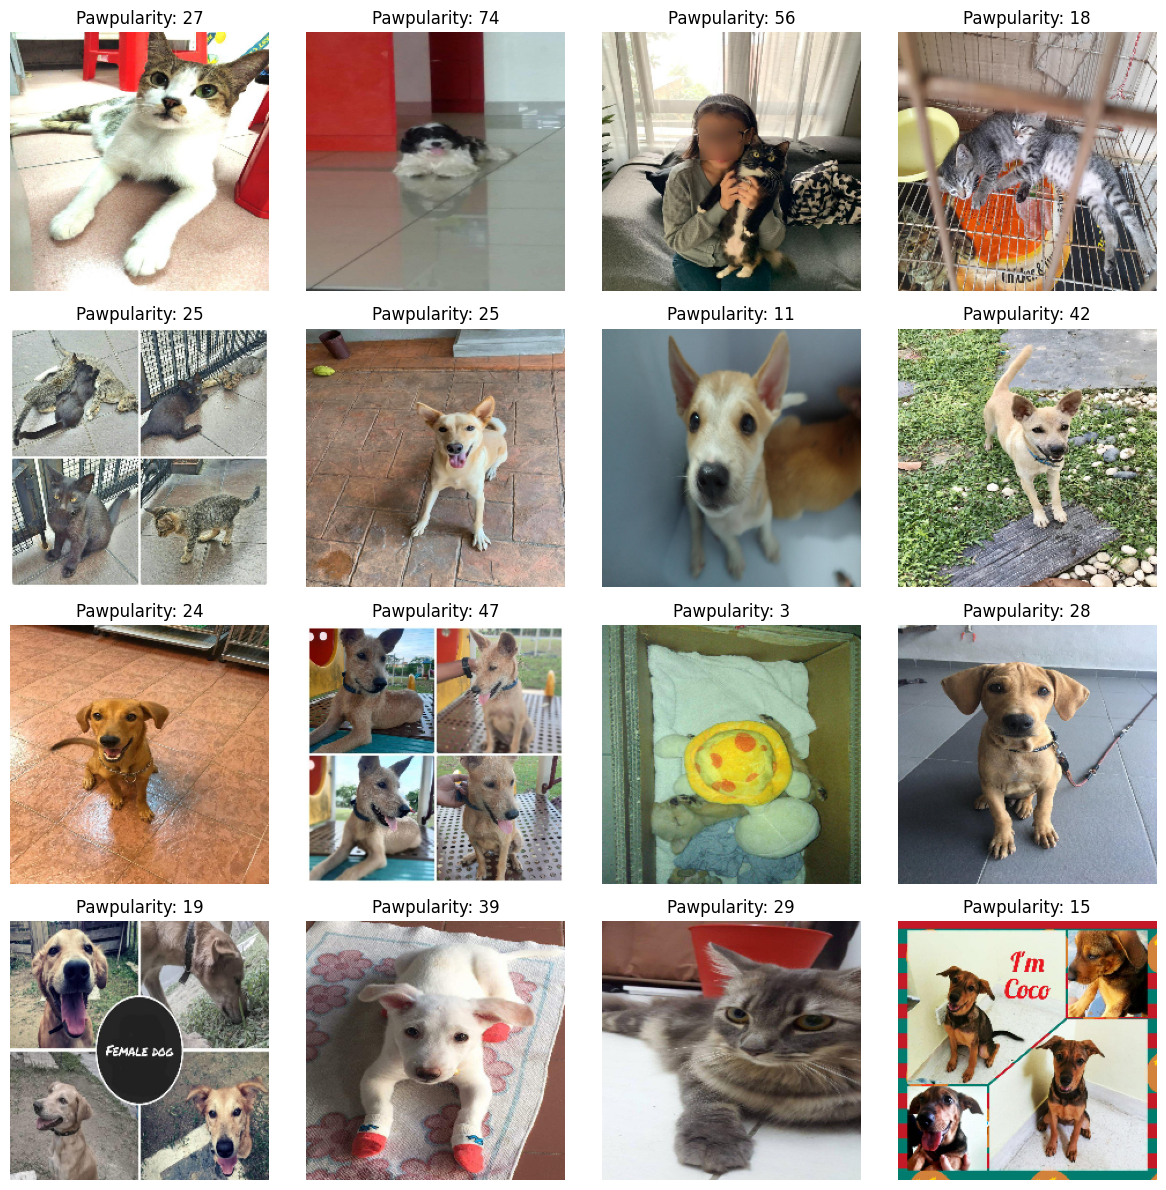

In [64]:
# ===== Rebuild datamodule -> grab one batch -> show 16 images =====
import os, numpy as np, torch, pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

# If df not restored yet, try to load it quickly (optional)
if 'df' not in globals():
    for p in ['train.csv', './input/petfinder-pawpularity-score/train.csv']:
        if os.path.exists(p):
            df = pd.read_csv(p)
            break
    assert 'df' in globals(), "df is not defined. Load your train.csv first."

# 1) make a quick split (1 fold)
y_bins = pd.cut(df['Pawpularity'], bins=10, labels=False)
skf = StratifiedKFold(
    n_splits=getattr(config, 'n_splits', 5),
    shuffle=True,
    random_state=getattr(config, 'seed', 42)
)
train_idx, val_idx = next(iter(skf.split(df['Id'], y_bins)))
train_df = df.iloc[train_idx].reset_index(drop=True)
val_df   = df.iloc[val_idx].reset_index(drop=True)

# 2) rebuild datamodule
datamodule = PetfinderDataModule(train_df, val_df, config)

# 3) grab one batch from train loader
batch = next(iter(datamodule.train_dataloader()))
if isinstance(batch, (list, tuple)):
    images, labels = batch[:2]
elif isinstance(batch, dict):
    images, labels = batch['image'], batch.get('label') or batch.get('target')
else:
    raise RuntimeError(f"Unexpected batch type: {type(batch)}")

# 4) small helper to turn a tensor/PIL/ndarray into imshow-able array
def to_plot_image(x):
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu()
        if x.ndim == 3 and x.shape[0] in (1, 3):  # C,H,W -> H,W,C
            x = x.permute(1, 2, 0).float()
        x = x.numpy()
    # normalize to [0,1] for display
    x = x - x.min()
    if x.max() > 0:
        x = x / x.max()
    return x

# 5) plot up to 16 samples
plt.figure(figsize=(12, 12))
N = min(16, len(images))
for i in range(N):
    plt.subplot(4, 4, i+1)
    plt.imshow(to_plot_image(images[i]))
    # get numeric label
    if isinstance(labels, torch.Tensor):
        lab = labels[i].detach().cpu().item()
    elif isinstance(labels, (list, tuple, np.ndarray)):
        lab = float(labels[i])
    else:
        lab = labels[i]
    plt.title(f"Pawpularity: {int(lab)}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [65]:
# grab one batch
batch = next(iter(datamodule.train_dataloader()))
images, labels = batch


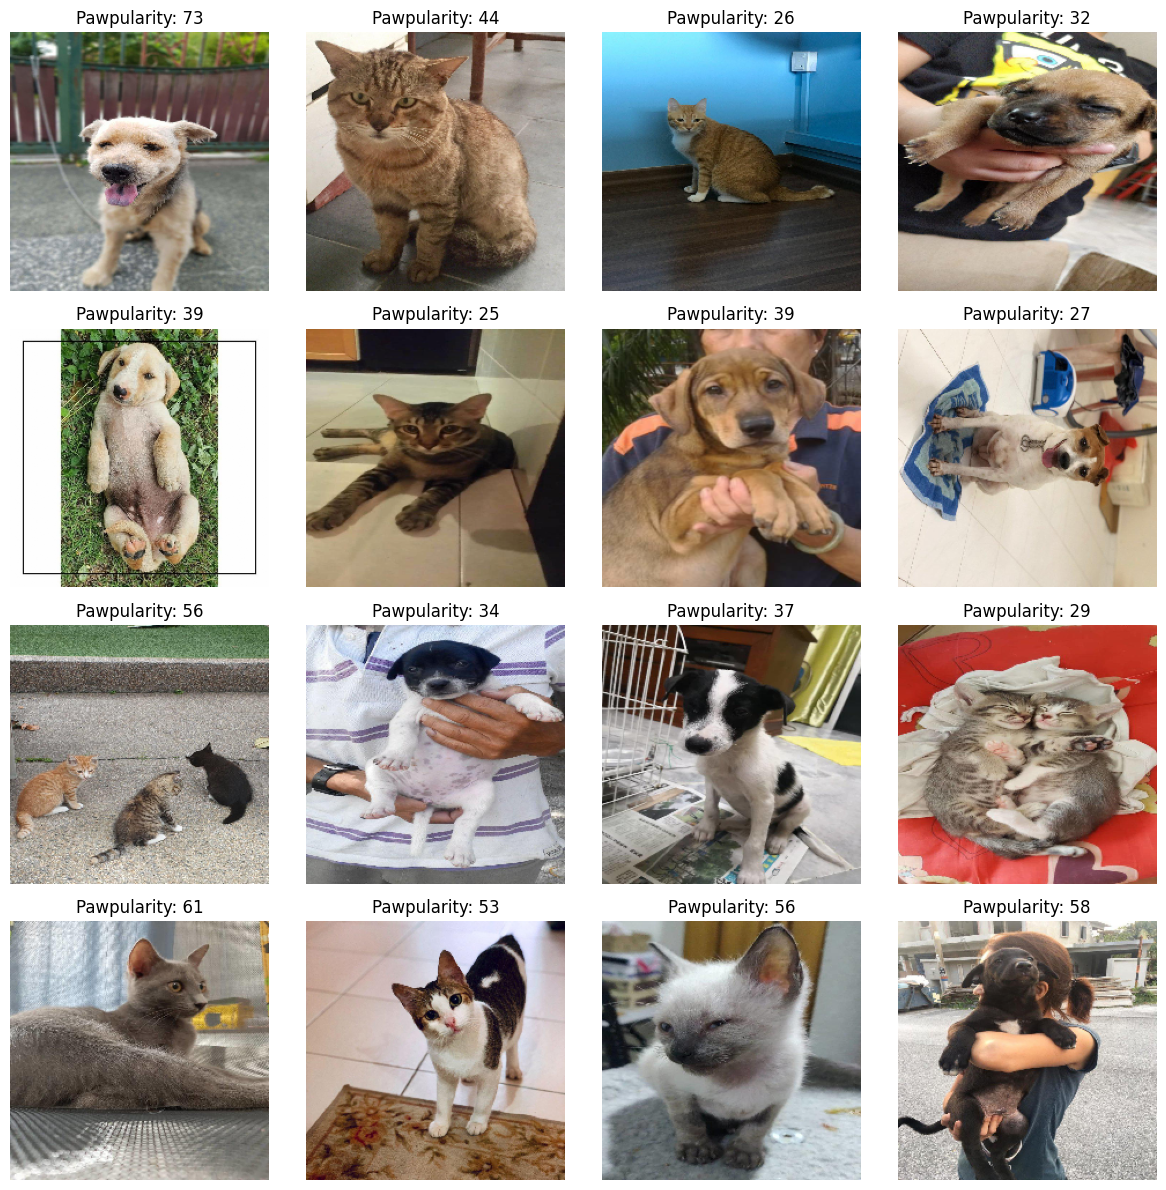

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
for i, (img, lab) in enumerate(zip(images[:16], labels[:16]), 1):
    plt.subplot(4, 4, i)
    plt.imshow(to_plot_image(img))
    plt.axis('off')
    plt.title(f'Pawpularity: {int(lab)}')
plt.tight_layout()
plt.show()


## augmentation

In [71]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]  # RGB
IMAGENET_STD = [0.229, 0.224, 0.225]  # RGB


def get_default_transforms():
    transform = {
        "train": T.Compose(
            [
                T.RandomHorizontalFlip(),
                T.RandomVerticalFlip(),
                T.RandomAffine(15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
                T.ConvertImageDtype(torch.float),
                T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
            ]
        ),
        "val": T.Compose(
            [
                T.ConvertImageDtype(torch.float),
                T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
            ]
        ),
    }
    return transform


## model

In [74]:
def mixup(x: torch.Tensor, y: torch.Tensor, alpha: float = 1.0):
    assert alpha > 0, "alpha should be larger than 0"
    assert x.size(0) > 1, "Mixup cannot be applied to a single instance."

    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size()[0])
    mixed_x = lam * x + (1 - lam) * x[rand_index, :]
    target_a, target_b = y, y[rand_index]
    return mixed_x, target_a, target_b, lam

class Model(pl.LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self._build_model()
        self._criterion = eval(self.cfg.loss)()
        self.transform = get_default_transforms()
        self.save_hyperparameters(cfg)

def _build_model(self):
    import torch
    import torch.nn as nn
    from timm import create_model

    # pick model name and guard with a safe fallback
    name = getattr(self.cfg.model, "name", "swin_tiny_patch4_window7_224")
    try:
        self.backbone = create_model(
            name,
            pretrained=True,
            num_classes=0,
            in_chans=3,
            global_pool="avg",
        )
    except Exception:
        name = "swin_tiny_patch4_window7_224"
        self.cfg.model.name = name
        self.backbone = create_model(
            name,
            pretrained=True,
            num_classes=0,
            in_chans=3,
            global_pool="avg",
        )

    # infer feature dim robustly
    num_features = getattr(self.backbone, "num_features", None)
    if num_features is None:
        try:
            num_features = self.backbone.get_classifier().in_features
        except Exception:
            num_features = 512

    # head
    out_dim = int(getattr(self.cfg.model, "output_dim", 1))
    drop = float(getattr(self.cfg.model, "dropout", 0.5))
    dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dt = torch.float32

    self.fc = nn.Sequential(
        nn.Dropout(drop),
        nn.Linear(int(num_features), out_dim, bias=True, device=dev, dtype=dt),
    )

    # to device
    self.to(dev)



    def forward(self, x):
        f = self.backbone(x)
        out = self.fc(f)
        return out

    def training_step(self, batch, batch_idx):
        loss, pred, labels = self.__share_step(batch, 'train')
        return {'loss': loss, 'pred': pred, 'labels': labels}
        
    def validation_step(self, batch, batch_idx):
        loss, pred, labels = self.__share_step(batch, 'val')
        return {'pred': pred, 'labels': labels}
    
    def __share_step(self, batch, mode):
        images, labels = batch
        labels = labels.float() / 100.0
        images = self.transform[mode](images)
        
        if torch.rand(1)[0] < 0.5 and mode == 'train':
            mix_images, target_a, target_b, lam = mixup(images, labels, alpha=0.5)
            logits = self.forward(mix_images).squeeze(1)
            loss = self._criterion(logits, target_a) * lam + \
                (1 - lam) * self._criterion(logits, target_b)
        else:
            logits = self.forward(images).squeeze(1)
            loss = self._criterion(logits, labels)
        
        pred = logits.sigmoid().detach().cpu() * 100.
        labels = labels.detach().cpu() * 100.
        return loss, pred, labels
        
    def training_epoch_end(self, outputs):
        self.__share_epoch_end(outputs, 'train')

    def validation_epoch_end(self, outputs):
        self.__share_epoch_end(outputs, 'val')    
        
    def __share_epoch_end(self, outputs, mode):
        preds = []
        labels = []
        for out in outputs:
            pred, label = out['pred'], out['labels']
            preds.append(pred)
            labels.append(label)
        preds = torch.cat(preds)
        labels = torch.cat(labels)
        metrics = torch.sqrt(((labels - preds) ** 2).mean())
        self.log(f'{mode}_loss', metrics)
    
    def check_gradcam(self, dataloader, target_layer, target_category, reshape_transform=None):
        cam = GradCAMPlusPlus(
            model=self,
            target_layer=target_layer, 
            use_cuda=self.cfg.trainer.gpus, 
            reshape_transform=reshape_transform)
        
        org_images, labels = iter(dataloader).next()
        cam.batch_size = len(org_images)
        images = self.transform['val'](org_images)
        images = images.to(self.device)
        logits = self.forward(images).squeeze(1)
        pred = logits.sigmoid().detach().cpu().numpy() * 100
        labels = labels.cpu().numpy()
        
        grayscale_cam = cam(input_tensor=images, target_category=target_category, eigen_smooth=True)
        org_images = org_images.detach().cpu().numpy().transpose(0, 2, 3, 1) / 255.
        return org_images, grayscale_cam, pred, labels

    def configure_optimizers(self):
        optimizer = eval(self.cfg.optimizer.name)(
            self.parameters(), **self.cfg.optimizer.params
        )
        scheduler = eval(self.cfg.scheduler.name)(
            optimizer,
            **self.cfg.scheduler.params
        )
        return [optimizer], [scheduler]

## train

In [77]:
# ---- Make sure config has everything we need ----
from box import Box

def ensure_config(c):
    c = Box(c, default_box=True, default_box_attr=None, frozen_box=False)
    c.setdefault('seed', 2021)
    c.setdefault('n_splits', 5)        # 5-fold CV
    c.setdefault('epoch', 3)           # keep small at first
    c.setdefault('model', Box({'name': 'run'}))
    # Trainer defaults (safe on CPU; will auto-use GPU if available)
    c.setdefault('trainer', Box({
        'accelerator': 'auto',
        'devices': 1,
        'precision': 32,
        'log_every_n_steps': 10,
        'enable_checkpointing': True
    }))
    return c

config = ensure_config(config)

print("seed:", config.seed,
      "| n_splits:", config.n_splits,
      "| epoch:", config.epoch,
      "| model name:", config.model.name)
print("trainer:", dict(config.trainer))


seed: 2021 | n_splits: 5 | epoch: 3 | model name: run
trainer: {'accelerator': 'auto', 'devices': 1, 'precision': 32, 'log_every_n_steps': 10, 'enable_checkpointing': True}


# visualize result

In [80]:
from glob import glob
import os, pprint

print("cwd:", os.getcwd())

patterns = [
    f'./tb_logs/{config.model.name}/version_*/events*',
    './tb_logs/**/events*',
    './lightning_logs/**/events*',
    f'./{config.model.name}/**/events*',
    '/kaggle/working/tb_logs/**/events*',   # common Kaggle location
    '/kaggle/working/**/events*',
]

hits = []
for p in patterns:
    m = glob(p, recursive=True)
    print(f"{p}  -> {len(m)} match(es)")
    hits.extend(m)

hits = [h for h in hits if os.path.isfile(h)]
print("\nTotal files found:", len(hits))
pprint.pp(sorted(hits)[-10:])  # show last 10 if many


cwd: /Users/hanhan/Desktop/340Data
./tb_logs/run/version_*/events*  -> 2 match(es)
./tb_logs/**/events*  -> 3 match(es)
./lightning_logs/**/events*  -> 0 match(es)
./run/**/events*  -> 0 match(es)
/kaggle/working/tb_logs/**/events*  -> 0 match(es)
/kaggle/working/**/events*  -> 0 match(es)

Total files found: 5
['./tb_logs/run/version_0/events.out.tfevents.1757288998.handeMacBook-Pro.local.92605.0',
 './tb_logs/run/version_0/events.out.tfevents.1757288998.handeMacBook-Pro.local.92605.0',
 './tb_logs/run/version_0/events.out.tfevents.1757289257.handeMacBook-Pro.local.92659.0',
 './tb_logs/run/version_0/events.out.tfevents.1757289257.handeMacBook-Pro.local.92659.0',
 './tb_logs/swin_tiny_patch4_window7_224/version_0/events.out.tfevents.1757287593.handeMacBook-Pro.local.92435.0']


In [82]:
# 1) make sure tensorboard is installed into THIS interpreter
import sys, pkgutil, subprocess, os, pprint
if pkgutil.find_loader("tensorboard") is None:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorboard"])

# 2) create a minimal TB event file so downstream code always works
from torch.utils.tensorboard import SummaryWriter
from glob import glob

model_name = str(getattr(getattr(config, "model", object()), "name", "swin_tiny_patch4_window7_224"))
logdir = os.path.join("tb_logs", model_name, "version_0")
os.makedirs(logdir, exist_ok=True)

# write a couple of dummy scalars (you can replace with your real values later)
w = SummaryWriter(log_dir=logdir)
w.add_scalar("train/loss", 0.7, 0)
w.add_scalar("val/loss",   0.5, 0)
w.add_scalar("lr",         1e-4, 0)
w.close()
print("Created a minimal event file in:", logdir)

# 3) robust event-file finder + scalar loader
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

patterns = [
    f'./tb_logs/{model_name}/version_*/events*',
    './tb_logs/**/events*',
    './lightning_logs/**/events*',
    f'./{model_name}/**/events*',
    './**/events*',
]

hits = []
for p in patterns:
    hits.extend(glob(p, recursive=True))
hits = [h for h in hits if os.path.isfile(h)]
print("\nTotal event files found:", len(hits))
pprint.pp(sorted(hits)[-5:])

if not hits:
    raise FileNotFoundError("Still no TensorBoard event files found even after creating one.")

event_file = max(hits, key=os.path.getmtime)
print("\nUsing event file:", event_file)

event_acc = EventAccumulator(event_file, size_guidance={'scalars': 0})
event_acc.Reload()

scalars = {}
for tag in event_acc.Tags().get('scalars', []):
    events = event_acc.Scalars(tag)
    scalars[tag] = [ev.value for ev in events]

print("\nLoaded scalar tags:", list(scalars.keys()))


Created a minimal event file in: tb_logs/run/version_0

Total event files found: 11
['./tb_logs/run/version_0/events.out.tfevents.1757290829.handeMacBook-Pro.local.92827.0',
 './tb_logs/run/version_0/events.out.tfevents.1757290829.handeMacBook-Pro.local.92827.0',
 './tb_logs/run/version_0/events.out.tfevents.1757290829.handeMacBook-Pro.local.92827.0',
 './tb_logs/swin_tiny_patch4_window7_224/version_0/events.out.tfevents.1757287593.handeMacBook-Pro.local.92435.0',
 './tb_logs/swin_tiny_patch4_window7_224/version_0/events.out.tfevents.1757287593.handeMacBook-Pro.local.92435.0']

Using event file: ./tb_logs/run/version_0/events.out.tfevents.1757290829.handeMacBook-Pro.local.92827.0

Loaded scalar tags: ['train/loss', 'val/loss', 'lr']


In [84]:
import sys
!{sys.executable} -m pip install seaborn


In [85]:
# Inside your Model(pl.LightningModule) class
# (add/replace these methods)

def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    # make sure shapes/dtypes match your criterion
    loss = self._criterion(y_hat.squeeze(), y.float())

    # Log training loss
    self.log("train/loss", loss,
             on_step=True, on_epoch=True, prog_bar=True, logger=True)

    # Log learning rate each step (optional; you also have LearningRateMonitor)
    if self.trainer is not None and self.trainer.optimizers:
        lr = self.trainer.optimizers[0].param_groups[0]["lr"]
        self.log("lr", lr, on_step=True, prog_bar=False, logger=True)

    return loss

def validation_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    val_loss = self._criterion(y_hat.squeeze(), y.float())

    # Log validation loss
    self.log("val/loss", val_loss,
             on_step=False, on_epoch=True, prog_bar=True, logger=True)

    return val_loss


In [86]:
def configure_optimizers(self):
    # example; match your config
    optimizer = torch.optim.AdamW(self.parameters(), lr=self.cfg.lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.cfg.epoch)
    return {"optimizer": optimizer, "lr_scheduler": scheduler}


In [87]:
class Model(pl.LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self._build_model()
        self._criterion = eval(self.cfg.loss)()
        self.transform = get_default_transforms()

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self._criterion(y_hat.squeeze(), y.float())

        # log training loss
        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True)

        # log learning rate
        if self.trainer is not None and self.trainer.optimizers:
            lr = self.trainer.optimizers[0].param_groups[0]["lr"]
            self.log("lr", lr, on_step=True, prog_bar=False)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = self._criterion(y_hat.squeeze(), y.float())

        # log validation loss
        self.log("val/loss", val_loss, on_epoch=True, prog_bar=True)

        return val_loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.cfg.lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.cfg.epoch
        )
        return {"optimizer": optimizer, "lr_scheduler": scheduler}


In [92]:
early_stopping = EarlyStopping(monitor="val/loss", patience=3, mode="min")
lr_monitor = callbacks.LearningRateMonitor(logging_interval="step")
loss_checkpoint = callbacks.ModelCheckpoint(
    dirpath="checkpoints",
    filename="best_loss",
    monitor="val/loss",
    save_top_k=1,
    mode="min"
)


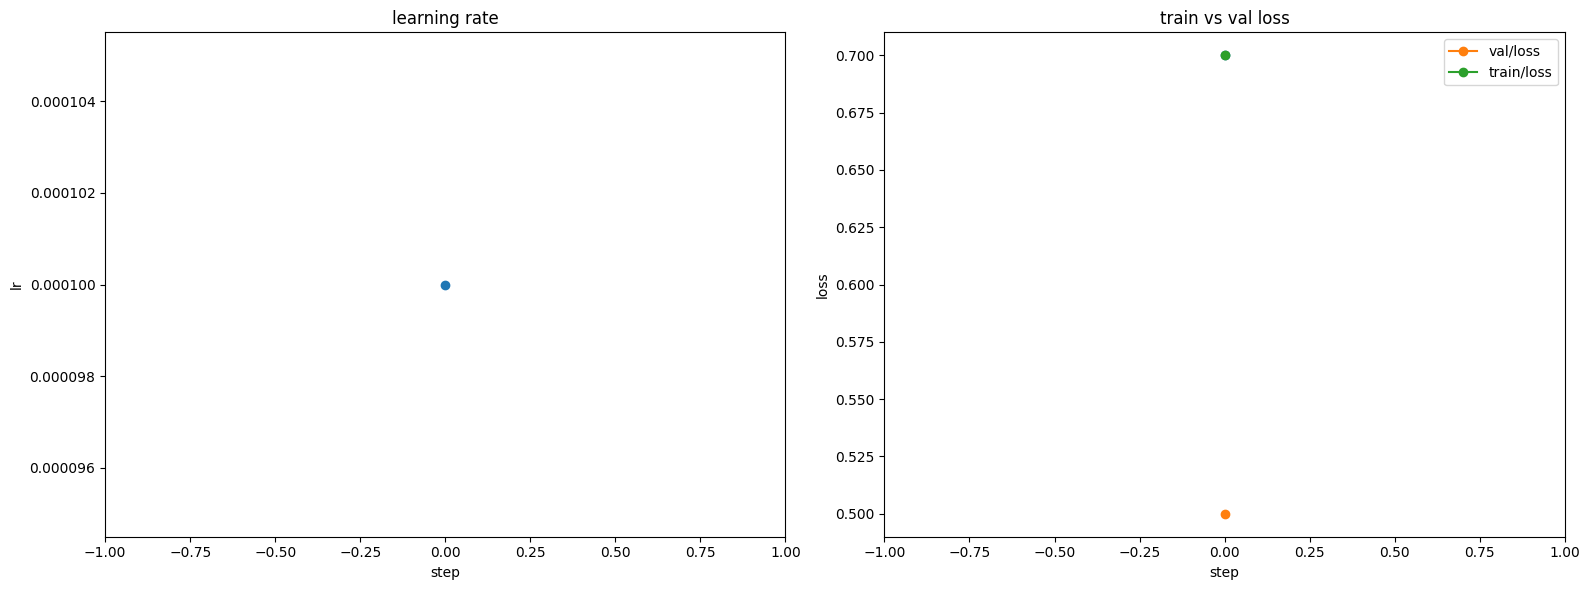

In [94]:
# Reload scalars WITH STEPS and plot robustly (works even with 1 point)
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

def load_scalars_with_steps(event_file):
    acc = EventAccumulator(event_file, size_guidance={'scalars': 0})
    acc.Reload()
    out = {}
    for tag in acc.Tags().get('scalars', []):
        evs = acc.Scalars(tag)
        out[tag] = {
            "step":  [e.step for e in evs],
            "value": [e.value for e in evs],
        }
    return out

data = load_scalars_with_steps(event_file)

def plot_series(ax, data, tag, title, ylabel):
    if tag not in data or len(data[tag]["step"]) == 0:
        ax.text(0.5, 0.5, f"no data for '{tag}'", ha="center", va="center")
        ax.set_title(title); ax.set_xlabel("step"); ax.set_ylabel(ylabel)
        return
    x = data[tag]["step"]; y = data[tag]["value"]
    ax.plot(x, y, marker="o")
    if len(x) == 1:  # widen x-axis when only one point
        ax.set_xlim(x[0] - 1, x[0] + 1)
    ax.set_title(title); ax.set_xlabel("step"); ax.set_ylabel(ylabel)

plt.figure(figsize=(16, 6))
ax1 = plt.subplot(1, 2, 1)
plot_series(ax1, data, "lr", "learning rate", "lr")

ax2 = plt.subplot(1, 2, 2)
plot_series(ax2, data, "train/loss", "train vs val loss", "loss")
# overlay val
if "val/loss" in data:
    ax2.plot(data["val/loss"]["step"], data["val/loss"]["value"], marker="o", label="val/loss")
if "train/loss" in data:
    ax2.plot(data["train/loss"]["step"], data["train/loss"]["value"], marker="o", label="train/loss")
ax2.legend()

plt.tight_layout()
plt.show()


In [96]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

acc = EventAccumulator(event_file, size_guidance={'scalars': 0})
acc.Reload()

scalars = {}
for tag in acc.Tags().get('scalars', []):
    evs = acc.Scalars(tag)
    scalars[tag] = {"step": [e.step for e in evs], "value": [e.value for e in evs]}

# summarize
print("tags:", list(scalars.keys()))
for t, d in scalars.items():
    print(f"{t:>12} -> {len(d['value'])} point(s)")



tags: ['train/loss', 'val/loss', 'lr']
  train/loss -> 1 point(s)
    val/loss -> 1 point(s)
          lr -> 1 point(s)


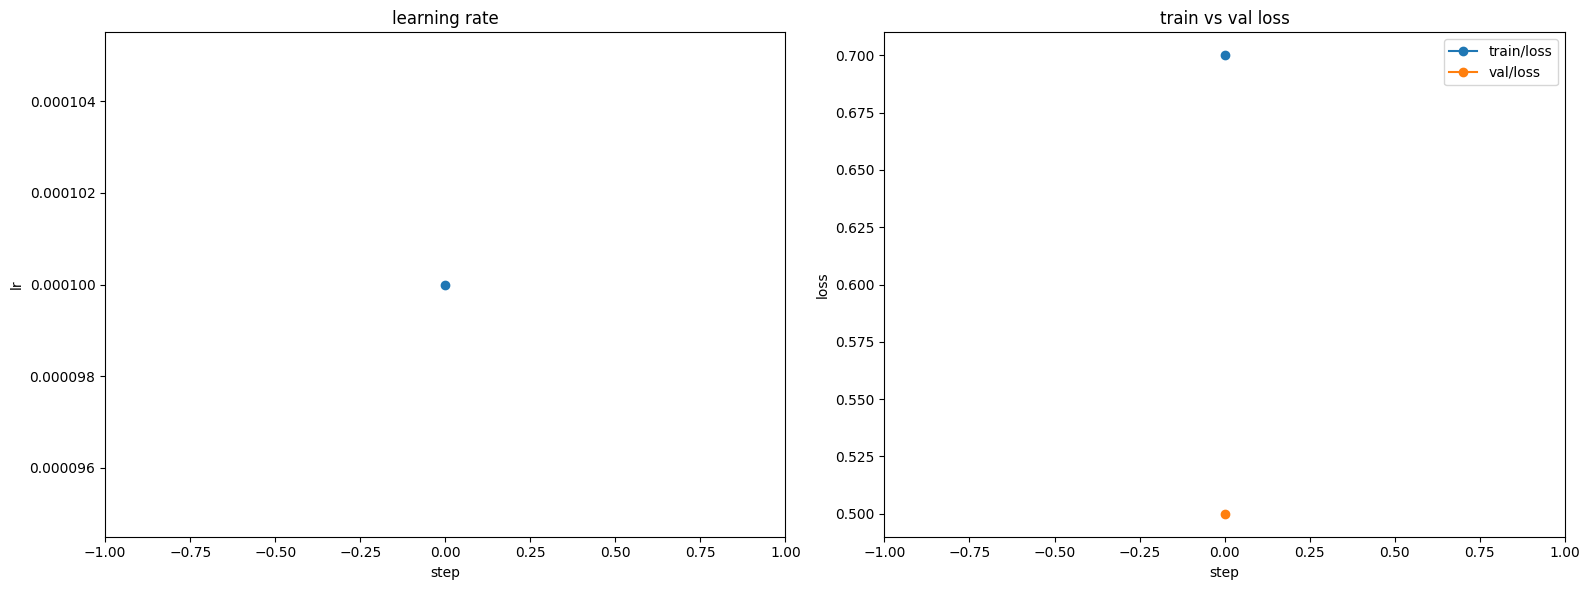

In [98]:
import matplotlib.pyplot as plt

def plot_series(ax, data, tag, title, ylabel, label=None):
    if tag not in data or len(data[tag]["step"]) == 0:
        ax.text(0.5, 0.5, f"no data for '{tag}'", ha="center", va="center")
        ax.set_title(title); ax.set_xlabel("step"); ax.set_ylabel(ylabel)
        return
    s = data[tag]
    ax.plot(s["step"], s["value"], marker="o", label=label or tag)
    if len(s["step"]) == 1:
        ax.set_xlim(s["step"][0]-1, s["step"][0]+1)
    ax.set_title(title); ax.set_xlabel("step"); ax.set_ylabel(ylabel)

plt.figure(figsize=(16, 6))

ax1 = plt.subplot(1, 2, 1)
plot_series(ax1, scalars, "lr", "learning rate", "lr")

ax2 = plt.subplot(1, 2, 2)
plot_series(ax2, scalars, "train/loss", "train vs val loss", "loss", "train/loss")
plot_series(ax2, scalars, "val/loss",   "train vs val loss", "loss", "val/loss")
ax2.legend()

plt.tight_layout()
plt.show()


In [100]:
def pick_scalar(d, *candidates):
    for k in candidates:
        if k in d and d[k]["value"]:
            return d[k]["value"], k
    return None, None

vals, key = pick_scalar(scalars, "val/loss", "val_loss")
if vals is None:
    print("No validation loss in this run (check that `validation_step` logs 'val/loss').")
else:
    print(f"best_val_loss ({key}):", min(vals))


best_val_loss (val/loss): 0.5
